In [54]:
import pandas as pd
from cuml.cluster import KMeans as cuKMeans
from sklearn.preprocessing import StandardScaler
from cuml.metrics import adjusted_rand_score
import cupy as cp
import optuna
import numpy as np
from cuml import NearestNeighbors as cuNearestNeighbors
from sklearn.metrics import silhouette_score, make_scorer
import cudf
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as cu_silhouette_score
from sklearn.metrics import adjusted_rand_score, mutual_info_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer
import os
import gc
from sklearn.model_selection import GridSearchCV
import pickle
import joblib
from cuml.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

In [42]:

class ClusteringMetrics:
    def __init__(self, X, model):
        if isinstance(X, pd.DataFrame):
            self.X = X.reset_index(drop=True)
        else:
            self.X = pd.DataFrame(X).reset_index(drop=True)
        self.model = model

    def train(self):
        self.model.fit(self.X)

    def compute_internalEvaluation(self):
        if hasattr(self.model, 'predict'):
            y_pred = self.model.predict(self.X)
        elif hasattr(self.model, 'labels_'):
            y_pred = self.model.labels_
        else:
            raise AttributeError("The model does not have a valid method to predict cluster labels.")

        # Exclude noise points for Silhouette Score
        valid_points = y_pred != -1
        if len(set(y_pred[valid_points])) < 2:
            raise ValueError("Cannot compute Silhouette Score with less than 2 clusters (excluding noise).")

        self.shiloette_score = cu_silhouette_score(cp.asarray(self.X[valid_points]), cp.asarray(y_pred[valid_points]))
        self.calinski_harabasz_score = calinski_harabasz_score(self.X, y_pred)
        self.davies_bouldin_score = davies_bouldin_score(self.X, y_pred)


    def compute_externalEvaluation(self, y_true=None):
        self.y_true  = np.round(y_true).astype(int)
        if self.y_true is None:
            raise ValueError("Ground truth labels (y_true) are required for external evaluation.")

        if hasattr(self.model, 'predict'):
            y_pred = self.model.predict(self.X)
        elif hasattr(self.model, 'labels_'):
            y_pred = self.model.labels_
        else:
            raise AttributeError("The model does not have a valid method to predict cluster labels.")

        self.adjusted_rand = adjusted_rand_score(self.y_true, y_pred)
        self.mutual_info = mutual_info_score(self.y_true, y_pred)
        self.homogeneity = homogeneity_score(self.y_true, y_pred)
        self.completeness = completeness_score(self.y_true, y_pred)
        self.v_measure = v_measure_score(self.y_true, y_pred)

    def print_metrics(self):
        print(f"Silhouette Score: {self.shiloette_score}")
        print(f"Calinski Harabasz Score: {self.calinski_harabasz_score}")
        print(f"Davies Bouldin Score: {self.davies_bouldin_score}")
        if hasattr(self, 'adjusted_rand'):
            print(f"Adjusted Rand Index: {self.adjusted_rand}")
            print(f"Mutual Information Score: {self.mutual_info}")
            print(f"Homogeneity Score: {self.homogeneity}")
            print(f"Completeness Score: {self.completeness}")
            print(f"V-Measure Score: {self.v_measure}")

    def save_model(self, path):
        directory = os.path.dirname(path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        joblib.dump(self.model, path)

    def save_model_with_pickle(self, path):
        # Crear el directorio si no existe
        directory = os.path.dirname(path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Guardar el modelo usando pickle
        with open(path, 'wb') as file:
            pickle.dump(self.model, file)

In [43]:
df = pd.read_parquet('../data/processed/selected_features_df.parquet')
df.shape

(266469, 97)

We will standardize the data before applying KMeans algorithms since it is sensitive to the scale of the data due to the use of the Euclidean distance.

In [44]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

X_gpu = cudf.DataFrame(X_scaled)

## HOPKINS STATISTIC

First, we are going to compute the Hopkins statistic to check if data present a cluster tendency or if it is uniformly distributed.

In [4]:
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)
    nbrs = cuNearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = np.random.rand(n, d)
    ujd = []
    wjd = []

    for j in range(m):
        u_dist, _ = nbrs.kneighbors(rand_X[j].reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[j].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if np.isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [16]:
h_statistic = hopkins(df)
print(f"Hopkins Statistic: {h_statistic}")

Hopkins Statistic: 0.9645846964724479


The Hopkins statistic is very close to 1, so we can say that the data is good for clustering.

## KMeans

Since KKeans is an algorithm that needs a number of clusters as a hyperparameter, we will use the elbow method in order to discover the number of clusters. This method works by computing the sum of squared distances (inertia) from points to their centroids. We will choose the point were the curve starts to flatten. It is important to mention that because of the size of our dataset we will be using Minibatch KMeans to apply this method.

In [4]:
n_rows = X_scaled.shape[0]
K = range(1,11)
inertias = []
for k in K:
    mbkmeans=MiniBatchKMeans(n_clusters=k, batch_size=3000)
    mbkmeans.fit(X_scaled)
    inertias.append(mbkmeans.inertia_)

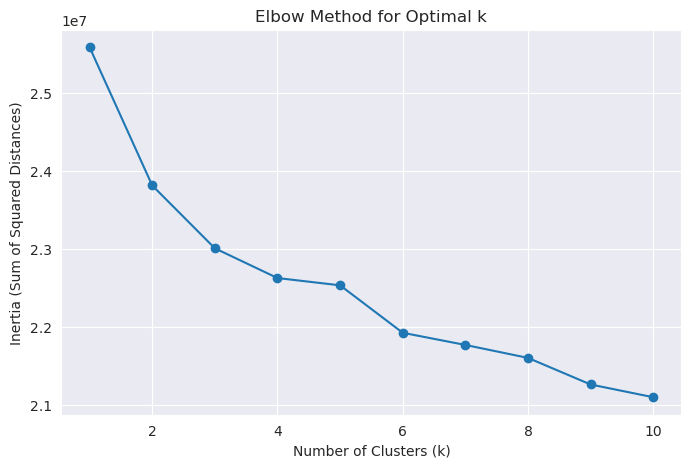

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

As we can see in the plot above, the elbow is at k = 3, so we are going to pick 3 clusters as the number of clusters. Now, we will perform hyperparameter tuning with n_clusters = 3.

In [45]:
X_scaled = pd.DataFrame(X_scaled)
X_reduced = X_scaled.sample(n=50000, random_state=42)
X_gpu = cudf.DataFrame(X_reduced)

### Hyperparameter tuning

In [23]:
def objective(trial):
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1)
    n_init = trial.suggest_int('n_init', 1, 10)
    km = cuKMeans(n_clusters=3, init=init, max_iter=max_iter, tol=tol, n_init=n_init)
    labels = km.fit_predict(X_gpu)
    score = silhouette_score(X_reduced, labels.to_numpy())
    return score

In [24]:
study = optuna.create_study(direction='maximize', study_name='kmeans_tuning')
study.optimize(objective, n_trials=5)

[I 2024-12-21 11:27:04,749] A new study created in memory with name: kmeans_tuning
[I 2024-12-21 11:27:22,468] Trial 0 finished with value: 0.0655806818419322 and parameters: {'init': 'k-means++', 'max_iter': 604, 'tol': 0.046930191242524955, 'n_init': 4}. Best is trial 0 with value: 0.0655806818419322.
[I 2024-12-21 11:27:40,599] Trial 1 finished with value: 0.0655806818419322 and parameters: {'init': 'k-means++', 'max_iter': 997, 'tol': 0.015579173755999372, 'n_init': 9}. Best is trial 0 with value: 0.0655806818419322.
[I 2024-12-21 11:27:58,920] Trial 2 finished with value: 0.0654502234707574 and parameters: {'init': 'random', 'max_iter': 574, 'tol': 0.026869552363844754, 'n_init': 5}. Best is trial 0 with value: 0.0655806818419322.
[I 2024-12-21 11:28:17,274] Trial 3 finished with value: 0.06564651689573334 and parameters: {'init': 'random', 'max_iter': 586, 'tol': 0.03255103464395796, 'n_init': 8}. Best is trial 3 with value: 0.06564651689573334.
[I 2024-12-21 11:28:35,427] Trial 

In [25]:
optuna.visualization.plot_param_importances(study)

From this plot can be observed that the most important hyperparameteres (excluding the number of clusters) is n_init which is the number of times the algorithm will run with different centroids. We can see also that it does not make a big difference wether to initialize the centroids randomly or using k-means++ technique, which chooses the centroids using sampling based on an empirical probability distribution of the points contribution to the overall inertia.

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

The best of our trials presents a silhouette score of 0.08 which is a very low score meaning that the clusters are not
well-defined. However, this algorithm works well with spherical clusters, and we might not have this kind of clusters in our dataset. We will need to evaluate other metrics to determine the quality of our model.

In [96]:
X_scaled = cp.asarray(X_scaled)
model = cuKMeans(**study.best_params)
metrics = ClusteringMetrics(X_scaled, model)
metrics.train()
metrics.save_model("../models/kmeans.pkl")
metrics.compute_internalEvaluation()
metrics.print_metrics()

ValueError: No trials are completed yet.

The silhouette score is very low, suggesting that samples of the same cluster are not very similar to other samples in the same cluster. According to the Davies Bouldin score the model presents a score of 3.41 which is high. This score suggests that our clusters are not well defined and probably are very close to each other. Finally, the Calinsky Harabasz score is very high and this is due to the size of our dataset. This score suggests that separation between clusters is moderate or high in relation to the compactness of individual clusters.

This scores suggest that the algorithm may have find some structure in our dataset but probably the clusters found are overlapping or have low intra cluster similarity.

### External evaluation

For the external evaluation we will train a model with n_clusters = 2 (Default/No Default)

In [97]:
X_reduced = X_scaled.sample(n=50000, random_state=42)

In [100]:
def objective(trial):
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_float('tol', 1e-5, 1e-1)
    n_init = trial.suggest_int('n_init', 1, 10)
    km = cuKMeans(n_clusters=2, init=init, max_iter=max_iter, tol=tol, n_init=n_init)
    labels = km.fit_predict(X_gpu)
    score = cu_silhouette_score(cp.asarray(X_reduced), cp.asarray(labels))
    return score

In [101]:
study = optuna.create_study(study_name='kmeans_external', direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-12-22 21:47:18,535] A new study created in memory with name: kmeans_external
[I 2024-12-22 21:47:23,140] Trial 0 finished with value: 0.06788638454138018 and parameters: {'init': 'k-means++', 'max_iter': 481, 'tol': 0.0871890108890532, 'n_init': 2}. Best is trial 0 with value: 0.06788638454138018.
[I 2024-12-22 21:47:27,114] Trial 1 finished with value: 0.0678863845413802 and parameters: {'init': 'k-means++', 'max_iter': 312, 'tol': 0.02777130950212486, 'n_init': 3}. Best is trial 1 with value: 0.0678863845413802.
[I 2024-12-22 21:47:31,152] Trial 2 finished with value: 0.06788638454138018 and parameters: {'init': 'k-means++', 'max_iter': 205, 'tol': 0.04387879338646051, 'n_init': 5}. Best is trial 1 with value: 0.0678863845413802.
[I 2024-12-22 21:47:35,123] Trial 3 finished with value: 0.06788638454138018 and parameters: {'init': 'k-means++', 'max_iter': 632, 'tol': 0.015172662624574186, 'n_init': 2}. Best is trial 1 with value: 0.0678863845413802.
[I 2024-12-22 21:47:39,128]

In [102]:
df = pd.read_parquet('../data/processed/selected_features_df.parquet')
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [103]:
model = cuKMeans(**study.best_params, n_clusters = 2)
metrics = ClusteringMetrics(df_scaled, model)
metrics.train()
metrics.save_model("../models/kmeans_external.pkl")
metrics.compute_internalEvaluation()
metrics.compute_externalEvaluation(df_scaled['TARGET'])
metrics.print_metrics()

Silhouette Score: 0.06900829616268382
Calinski Harabasz Score: 19630.322704364906
Davies Bouldin Score: 2.507386650524434
Adjusted Rand Index: -0.02902495344932571
Mutual Information Score: 0.0011172376696726785
Homogeneity Score: 0.0040100593571080955
Completeness Score: 0.002460505923724563
V-Measure Score: 0.0030497412125272258


## OPTICS

We will use a sample even smaller than the one before because we can not run OPTICS in the GPU and it takes an infeasible time.

In [46]:
X_reduced = X_scaled.sample(n=10000, random_state=42)

### Hyperparameter Tuning

In [33]:
def objective(trial):
    max_eps = trial.suggest_float('eps', 8.0, 15.0)
    min_samples = trial.suggest_int('min_samples', 12, 20)

    model = OPTICS(max_eps=max_eps, min_samples=min_samples, metric="cosine")
    model.fit(X_reduced.to_numpy())
    y_pred = model.labels_
    unique_labels = np.unique(y_pred)
    n_clusters = len(unique_labels)

    if -1 in unique_labels:
        n_clusters -= 1  # Excluir el ruido


    if n_clusters < 2:
        return -1
    else:
        return cu_silhouette_score(cp.asarray(X_reduced), cp.asarray(y_pred))


In [34]:
study = optuna.create_study(direction='maximize', study_name='OPTICS')
study.optimize(objective, n_trials=2)

[I 2024-12-21 16:45:50,349] A new study created in memory with name: OPTICS


4


[I 2024-12-21 16:43:16,356] Trial 0 finished with value: 0.10944135166426147 and parameters: {'eps': 9.847871505295355, 'min_samples': 15}. Best is trial 0 with value: 0.10944135166426147.


7


[I 2024-12-21 16:44:18,935] Trial 1 finished with value: -0.08098581341910192 and parameters: {'eps': 13.342142748771352, 'min_samples': 13}. Best is trial 0 with value: 0.10944135166426147.


In [37]:
print(study.best_params)
eps = study.best_params['eps']
min_samples = study.best_params['min_samples']

{'eps': 9.847871505295355, 'min_samples': 15}


In [49]:
model = OPTICS(**study.best_params, metric='cosine')
metrics = ClusteringMetrics(cp.asnumpy(X_reduced), model)
metrics.train()
metrics.save_model("../models/OPTICS.pkl")
metrics.compute_internalEvaluation()
metrics.print_metrics()

Silhouette Score: 0.3531452857448034
Calinski Harabasz Score: 84.812886693263
Davies Bouldin Score: 1.7190411876881133


The silhouette score is considered moderate, meaning that there are some clusters but the structure is not well defined. Together with this, the Davies Boulding score suggests that the clusters are overlapping. The CH score is low for the size of the dataset and it means that there too many or too few clusters.

## Agglomerative Clustering

We will use a subset of 50000 rows

In [58]:
X_reduced = X_scaled.sample(n=50000, random_state=42)
X_gpu = cp.asarray(X_reduced)

In [73]:
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 1, 10)
    metric = trial.suggest_categorical('metric', ['cosine', 'euclidean'])
    n_neighbors = trial.suggest_int('n_neighbors', 5, 30)

    model = AgglomerativeClustering(n_clusters=n_clusters, metric = metric, n_neighbors = n_neighbors)
    model.fit(X_gpu)
    y_pred = model.labels_
    unique_labels = np.unique(y_pred)
    n_clusters = len(unique_labels)

    if -1 in unique_labels:
        n_clusters -= 1  # Excluir el ruido


    if n_clusters < 2:
        return -1
    else:
        return cu_silhouette_score(cp.asarray(X_reduced), cp.asarray(y_pred))

In [76]:
study = optuna.create_study(study_name='AgglomerativeClustering', direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-12-22 20:54:33,707] A new study created in memory with name: AgglomerativeClustering
[I 2024-12-22 20:54:38,367] Trial 0 finished with value: -0.20300583337077097 and parameters: {'n_clusters': 10, 'metric': 'cosine', 'n_neighbors': 22}. Best is trial 0 with value: -0.20300583337077097.
[I 2024-12-22 20:54:41,140] Trial 1 finished with value: -0.19588273645040638 and parameters: {'n_clusters': 7, 'metric': 'cosine', 'n_neighbors': 15}. Best is trial 1 with value: -0.19588273645040638.
[I 2024-12-22 20:54:45,029] Trial 2 finished with value: -0.19221949156873197 and parameters: {'n_clusters': 5, 'metric': 'cosine', 'n_neighbors': 19}. Best is trial 2 with value: -0.19221949156873197.
[I 2024-12-22 20:54:45,203] Trial 3 finished with value: -1.0 and parameters: {'n_clusters': 1, 'metric': 'euclidean', 'n_neighbors': 17}. Best is trial 2 with value: -0.19221949156873197.
[I 2024-12-22 20:54:49,126] Trial 4 finished with value: -0.1341858793342079 and parameters: {'n_clusters': 2, 

In [77]:
model = AgglomerativeClustering(**study.best_params)
metrics = ClusteringMetrics(X_scaled, model)
metrics.train()
metrics.save_model("../models/agglomerative.pkl")
metrics.compute_internalEvaluation()
metrics.print_metrics()

Silhouette Score: 0.35992020990680346
Calinski Harabasz Score: 3.7695618295292417
Davies Bouldin Score: 0.504829277908786


The silhouette score is almost the same as in the other algorithms and shows a moderate value that means clusters not properly defined. The Calinsky Harabasz score is very low according to the size of our dataset. The Davies Bouldin score suggest that clusters are compact and well separated since it has a value close to zero.

### External Evaluation

For performing the external evaluation we will perform Hyperparameter tuning for n_clusters = 2 (Default / No default).

In [79]:
def objective(trial):
    metric = trial.suggest_categorical('metric', ['cosine', 'euclidean'])
    n_neighbors = trial.suggest_int('n_neighbors', 5, 30)

    model = AgglomerativeClustering(metric = metric, n_neighbors = n_neighbors)
    model.fit(X_gpu)
    y_pred = model.labels_
    unique_labels = np.unique(y_pred)
    n_clusters = len(unique_labels)

    if -1 in unique_labels:
        n_clusters -= 1


    if n_clusters < 2:
        return -1
    else:
        return cu_silhouette_score(cp.asarray(X_reduced), cp.asarray(y_pred))

In [80]:
study = optuna.create_study(direction='maximize', study_name='AgglomerativeClustering_Ext')
study.optimize(objective, n_trials=30)

[I 2024-12-22 21:13:43,926] A new study created in memory with name: AgglomerativeClustering_Ext
[I 2024-12-22 21:13:48,561] Trial 0 finished with value: 0.35026178250881423 and parameters: {'metric': 'euclidean', 'n_neighbors': 28}. Best is trial 0 with value: 0.35026178250881423.
[I 2024-12-22 21:13:51,355] Trial 1 finished with value: -0.1341858793342079 and parameters: {'metric': 'cosine', 'n_neighbors': 9}. Best is trial 0 with value: 0.35026178250881423.
[I 2024-12-22 21:13:55,359] Trial 2 finished with value: 0.35026178250881423 and parameters: {'metric': 'euclidean', 'n_neighbors': 10}. Best is trial 0 with value: 0.35026178250881423.
[I 2024-12-22 21:13:59,290] Trial 3 finished with value: -0.1341858793342079 and parameters: {'metric': 'cosine', 'n_neighbors': 9}. Best is trial 0 with value: 0.35026178250881423.
[I 2024-12-22 21:14:03,444] Trial 4 finished with value: 0.35026178250881423 and parameters: {'metric': 'euclidean', 'n_neighbors': 18}. Best is trial 0 with value: 0.

In [93]:
df = pd.read_parquet('../data/processed/selected_features_df.parquet')
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [94]:
model = AgglomerativeClustering(**study.best_params)
metrics = ClusteringMetrics(df_scaled, model)
metrics.train()
metrics.save_model("../models/agglomerative_external.pkl")
metrics.compute_internalEvaluation()
metrics.compute_externalEvaluation(df_scaled['TARGET'])
metrics.print_metrics()

Silhouette Score: 0.35992020990680346
Calinski Harabasz Score: 3.7695618295292417
Davies Bouldin Score: 0.504829277908786
Adjusted Rand Index: -6.85324197191332e-06
Mutual Information Score: 3.1264540388489684e-07
Homogeneity Score: 1.122166447961587e-06
Completeness Score: 0.0061743302642225375
V-Measure Score: 2.2439250691117563e-06


This scores show that clusters are not well alligned with real labels. Clusters are not homogeneous, meaning that clusters are formed by clients from the class Default and Clients from the class No Default. In addition, the ARI score shows that predicted clusters do not coincide with true labels.